In [4]:
import sys
sys.path.append('/path/to/dicomsdl')

In [6]:
!pip install dicomsdl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.0 MB/s eta 0:00:0000:010:01


In [7]:
import os
import dicomsdl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [9]:
train=pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
train.head(5)

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='cancer', ylabel='count'>

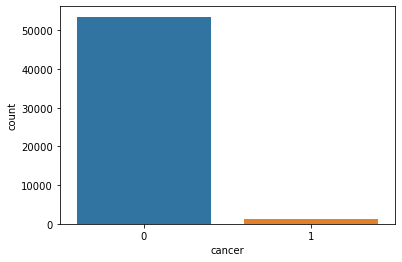

In [11]:
sns.countplot(train.cancer)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='view', ylabel='count'>

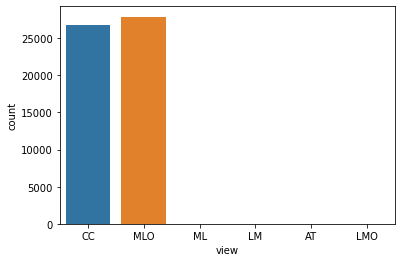

In [12]:
sns.countplot(train.view)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='invasive', ylabel='count'>

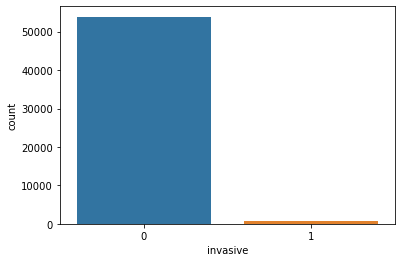

In [13]:
sns.countplot(train.invasive)

In [14]:
fig=px.line_polar(train,r='cancer',theta='view',color='invasive',line_group='biopsy',line_close=True,markers=True, direction='clockwise')
fig.show()

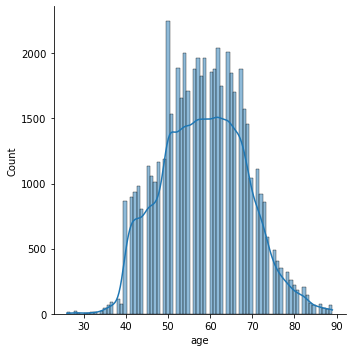

In [15]:
sns.displot(train,x='age',kde=True)

In [16]:
train[['laterality','cancer']].groupby(['laterality']).sum()

cancer
laterality        
L              588
R              570

In [17]:
px.pie(train,names='laterality',values='cancer')

In [18]:
test_df=pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')
test_df.head()

site_id  patient_id    image_id laterality view  age  implant  machine_id  \
0        2       10008   736471439          L  MLO   81        0          21   
1        2       10008  1591370361          L   CC   81        0          21   
2        2       10008    68070693          R  MLO   81        0          21   
3        2       10008   361203119          R   CC   81        0          21   

  prediction_id  
0       10008_L  
1       10008_L  
2       10008_R  
3       10008_R

In [19]:
test_df.shape


(4, 9)

In [20]:
test_df.isna().sum()

site_id          0
patient_id       0
image_id         0
laterality       0
view             0
age              0
implant          0
machine_id       0
prediction_id    0
dtype: int64

In [21]:
train.isna().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

In [22]:
train.shape

(54706, 14)

In [23]:
train=train.drop(['BIRADS','density'],axis=1)
train.shape

(54706, 12)

In [24]:
from sklearn.impute import SimpleImputer
mem=SimpleImputer(strategy='mean')
train['age']=mem.fit_transform(train[['age']])


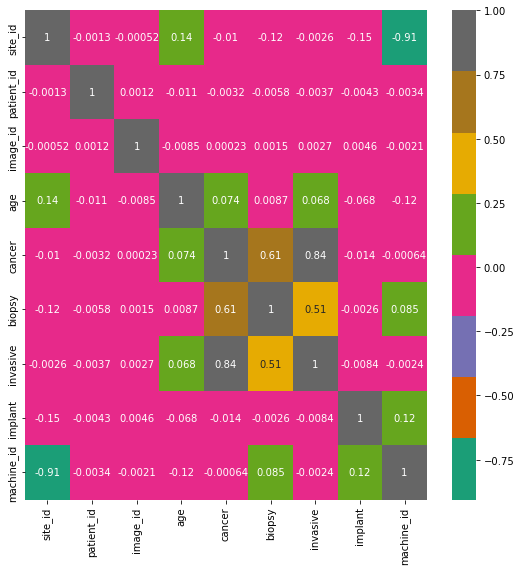

In [25]:

df=train.select_dtypes(include=(['int64','float64']))
plt.figure(figsize=(9,9))
sns.heatmap(df.corr(method='spearman'),cmap='Dark2',annot=True)
plt.show()

In [26]:
df.shape

(54706, 9)

In [27]:
image_data='/kaggle/input/rsna-breast-cancer-detection/{}_images/{}/{}.dcm'
train_image='train'
test_image='test'


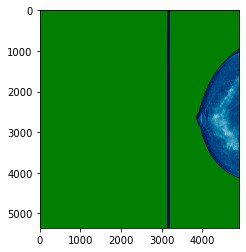

In [28]:
img=dicomsdl.open('/kaggle/input/rsna-breast-cancer-detection/train_images/10006/1874946579.dcm').pixelData()
plt.imshow(img,cmap='ocean_r')

In [29]:
patient_id=train[train.cancer==1].iloc[0].patient_id
patient_df=train[train.patient_id==patient_id]
patient_df

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
87        1       10130   388811999          L  MLO  71.0       1       1   
88        1       10130   613462606          L   CC  71.0       1       1   
89        1       10130  1360338805          L   CC  71.0       1       1   
90        1       10130  1672636630          L  MLO  71.0       1       1   
91        1       10130  1013166704          R   CC  71.0       0       0   
92        1       10130  1165309236          R   CC  71.0       0       0   
93        1       10130  2110820077          R  MLO  71.0       0       0   

    invasive  implant  machine_id  difficult_negative_case  
87         1        0          49                    False  
88         1        0          49                    False  
89         1        0          49                    False  
90         1        0          49                    False  
91         0        0          49                    False  
92         0        0          49                    False  
93         0        0          49                    False

In [32]:
import tensorflow as tf

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from keras_cv_attention_models import convnext

import cv2
import glob
import importlib
import os
import joblib
import time
import dicomsdl
import gc

In [33]:
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'

TARGET_HEIGHT = 1344
TARGET_WIDTH = 768
N_CHANNELS = 1
INPUT_SHAPE = (TARGET_HEIGHT, TARGET_WIDTH, N_CHANNELS)
TARGET_HEIGHT_WIDTH_RATIO = TARGET_HEIGHT / TARGET_WIDTH
THRESHOLD_BEST = 0.50

CLAHE = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32, 32))

CROP_IMAGE = True
APPLY_CLAHE = False
APPLY_EQ_HIST = False

IMAGE_FORMAT = 'jpg'

In [34]:
def voi_lut(image, dicom):
    if 'WindowWidth' not in dicom.getPixelDataInfo() or 'WindowWidth' not in dicom.getPixelDataInfo():
        return image
    
   
    center = dicom['WindowCenter']
    width = dicom['WindowWidth']
    bits_stored = dicom['BitsStored']
    voi_lut_function = dicom['VOILUTFunction']
    if isinstance(center, list):
        center = center[0]
    if isinstance(width, list):
        width = width[0]

    y_min = 0
    y_max = float(2**bits_stored - 1)
    y_range = y_max

   
    if voi_lut_function == 'SIGMOID':
        image = y_range / (1 + np.exp(-4 * (image - center) / width)) + y_min
    else:
       
        center -= 0.5
        width -= 1

        below = image <= (center - width / 2)
        above = image > (center + width / 2)
        between = np.logical_and(~below, ~above)

        image[below] = y_min
        image[above] = y_max
        if between.any():
            image[between] = (
                ((image[between] - center) / width + 0.5) * y_range + y_min
            )

    return image

In [35]:
def smooth(l):
    # kernel size is 1% of vector
    kernel_size = int(len(l) * 0.01)
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(l, kernel, mode='same')

# X Crop offset based on first column with sum below 5% of maximum column sums*std
def get_x_offset(image, max_col_sum_ratio_threshold=0.05, debug=None):
    # Image Dimensions
    H, W = image.shape
    # Percentual margin added to offset
    margin = int(image.shape[1] * 0.00)
    # Threshold values based on smoothed sum x std to capture varying intensity columns
    vv = smooth(image.sum(axis=0).squeeze()) * smooth(image.std(axis=0).squeeze())
    # Find maximum sum in first 75% of columns
    vv_argmax = vv[:int(image.shape[1] * 0.75)].argmax()
    # Threshold value
    vv_threshold = vv.max() * max_col_sum_ratio_threshold
    
    # Find first column after maximum column below threshold value
    for offset, v in enumerate(vv):
        # Start searching from vv_argmax
        if offset < vv_argmax:
            continue
        
        # Column below threshold value found
        if v < vv_threshold:
            offset = min(W, offset + margin)
            break
            
    if isinstance(debug, np.ndarray):
        debug[1].imshow(image)
        debug[1].set_title('X Offset')
        vv_scale = H / vv.max() * 0.90
        # Values
        debug[1].plot(H - vv * vv_scale , c='red', label='vv')
        # Threshold
        debug[1].hlines(H - vv_threshold * vv_scale, 0, W -1, colors='orange', label='threshold')
        # Max Value
        debug[1].scatter(vv_argmax, H - vv[vv_argmax] * vv_scale, c='blue', s=100, label='Max', zorder=np.PINF)
        # First Column Below Threshold
        debug[1].scatter(offset, H - vv[offset] * vv_scale, c='purple', s=100, label='Offset', zorder=np.PINF)
        debug[1].set_ylim(H, 0)
        debug[1].legend()
        debug[1].axis('off')
        
    return offset

# Y Crop offset based on first bottom and top rows with sum below 10% of maximum row sum*std
def get_y_offsets(image, max_row_sum_ratio_threshold=0.10, debug=None):
    # Image Dimensions
    H, W = image.shape
    # Margin to add to offsets
    margin = 0
    # Threshold values based on smoothed sum x std to capture varying intensity columns
    vv = smooth(image.sum(axis=1).squeeze()) * smooth(image.std(axis=1).squeeze())
    # Find maximum sum * std row in inter quartile rows
    vv_argmax = int(image.shape[0] * 0.25) + vv[int(image.shape[0] * 0.25):int(image.shape[0] * 0.75)].argmax()
    # Threshold value
    vv_threshold = vv.max() * max_row_sum_ratio_threshold
    # Default crop offsets
    offset_bottom = 0
    offset_top = H

    # Bottom offset, search from argmax to bottom
    for offset in reversed(range(0, vv_argmax)):
        v = vv[offset]
        if v < vv_threshold:
            offset_bottom = offset
            break
    
    if isinstance(debug, np.ndarray):
        debug[2].imshow(image)
        debug[2].set_title('Y Bottom Offset')
        vv_scale = W / vv.max() * 0.90
        # Values
        debug[2].plot(vv * vv_scale, np.arange(H), c='red', label='vv')
        # Threshold
        debug[2].vlines(vv_threshold * vv_scale, 0, H -1, colors='orange', label='threshold')
        # Max Value
        debug[2].scatter(vv[vv_argmax] * vv_scale, vv_argmax, c='blue', s=100, label='Max', zorder=np.PINF)
        # First Column Below Threshold
        debug[2].scatter(vv[offset_bottom] * vv_scale, offset_bottom, c='purple', s=100, label='Offset', zorder=np.PINF)
        debug[2].set_ylim(H, 0)
        debug[2].legend()
        debug[2].axis('off')
            
    # Top offset, search from argmax to top
    for offset in range(vv_argmax, H):
        v = vv[offset]
        if v < vv_threshold:
            offset_top = offset
            break
            
    if isinstance(debug, np.ndarray):
        debug[3].imshow(image)
        debug[3].set_title('Y Top Offset')
        vv_scale = W / vv.max() * 0.90
        # Values
        debug[3].plot(vv * vv_scale, np.arange(H) , c='red', label='vv')
        # Threshold
        debug[3].vlines(vv_threshold * vv_scale, 0, H -1, colors='orange', label='threshold')
        # Max Value
        debug[3].scatter(vv[vv_argmax] * vv_scale, vv_argmax, c='blue', s=100, label='Max', zorder=np.PINF)
        # First Column Below Threshold
        debug[3].scatter(vv[offset_top] * vv_scale, offset_top, c='purple', s=100, label='Offset', zorder=np.PINF)
        debug[2].set_ylim(H, 0)
        debug[3].legend()
        debug[3].axis('off')
            
    return max(0, offset_bottom - margin), min(image.shape[0], offset_top + margin)

# Crop image and pad offsets to target image height/width ratio to preserve information
def crop(image, size=None, debug=False):
    # Image dimensions
    H, W = image.shape
    # Compute x/bottom/top offsets
    x_offset = get_x_offset(image, debug=debug)
    offset_bottom, offset_top = get_y_offsets(image[:,:x_offset], debug=debug)
    # Crop Height and Width
    h_crop = offset_top - offset_bottom
    w_crop = x_offset
    
    # Pad crop offsets to target aspect ratio
    if size is not None:
        # Height too large, pad x offset
        if (h_crop / w_crop) > TARGET_HEIGHT_WIDTH_RATIO:
            x_offset += int(h_crop / TARGET_HEIGHT_WIDTH_RATIO - w_crop)
        else:
            # Height too small, pad bottom/top offsets
            offset_bottom -= int(0.50 * (w_crop * TARGET_HEIGHT_WIDTH_RATIO - h_crop))
            offset_bottom_correction = max(0, -offset_bottom)
            offset_bottom += offset_bottom_correction

            offset_top += int(0.50 * (w_crop * TARGET_HEIGHT_WIDTH_RATIO - h_crop))
            offset_top += offset_bottom_correction
        
    # Crop Image
    image = image[offset_bottom:offset_top:,:x_offset]
        
    return image

In [36]:
def process(file_path, size=(TARGET_WIDTH, TARGET_HEIGHT), crop_image=CROP_IMAGE, apply_clahe=APPLY_CLAHE, apply_eq_hist=APPLY_EQ_HIST, debug=False, save=True):
    dicom = dicomsdl.open(file_path)
    image = dicom.pixelData()
    
    if debug:
        fig, axes = plt.subplots(1, 5, figsize=(20,10))
        image0 = np.copy(image)
        axes[0].imshow(image0)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
    else:
        axes = False
    
    try:
        image = voi_lut(image, dicom)
    except:
        pass
    
   
    if dicom.getPixelDataInfo()['PhotometricInterpretation'] == 'MONOCHROME1':
        image = np.max(image) - image
    image = (image - image.min()) / (image.max() - image.min())

    image = (image * 255).astype(np.uint8)
    
    h0, w0 = image.shape
    if image[:,int(-w0 * 0.10):].sum() > image[:,:int(w0 * 0.10)].sum():
        image = np.flip(image, axis=1)
    
    if crop_image:
        image = crop(image, debug=axes)
        
    if size is not None:
        h, w = image.shape
        if (h / w) > TARGET_HEIGHT_WIDTH_RATIO:
            pad = int(h / TARGET_HEIGHT_WIDTH_RATIO - w)
            image = np.pad(image, [[0,0], [0, pad]])
            h, w = image.shape
        else:
            pad = int(0.50 * (w * TARGET_HEIGHT_WIDTH_RATIO - h))
            image = np.pad(image, [[pad, pad], [0,0]])
            h, w = image.shape
        image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
        
    if apply_clahe:
        image = CLAHE.apply(image)
    if apply_eq_hist:
        image = cv2.equalizeHist(image)
           
    if debug:
        axes[4].imshow(image)
        axes[4].set_title('Processed Image')
        axes[4].axis('off')
        plt.show()
    if save:
        image_id = file_path.split('/')[-1].split('.')[0]
        if IMAGE_FORMAT == 'png':
            cv2.imwrite(f'{image_id}.png', image)
        else:
            cv2.imwrite(f'{image_id}.jpg', image, [cv2.IMWRITE_JPEG_QUALITY, 95])

In [37]:
train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
    
def get_file_path(args):
    patient_id, image_id = args
    return f'/kaggle/input/rsna-breast-cancer-detection/train_images/{patient_id}/{image_id}.dcm'
    
train['file_path'] = train[['patient_id', 'image_id']].apply(get_file_path, axis=1)

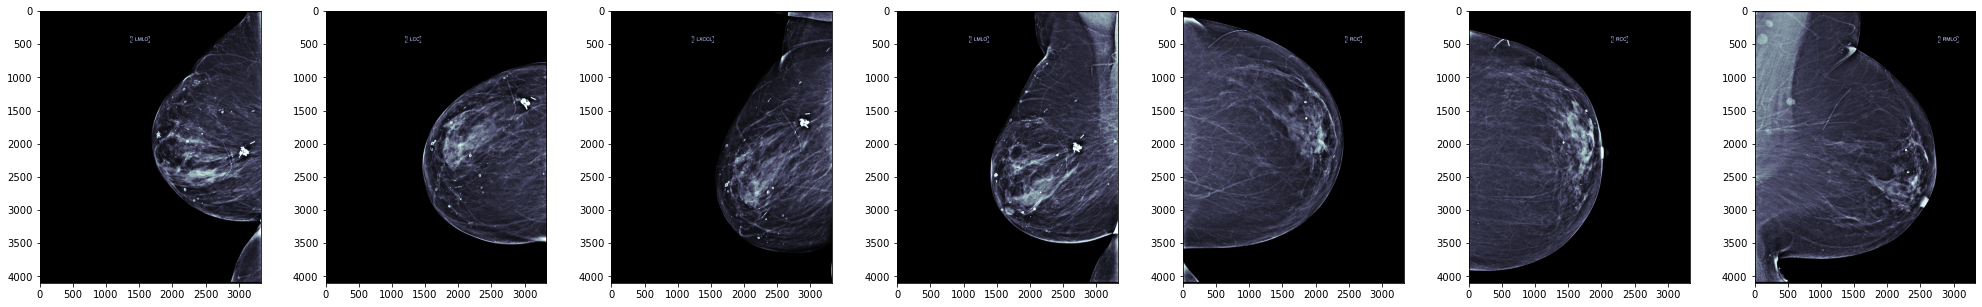

In [38]:
plt.figure(figsize=(5*len(patient_df),5))
for i in range(len(patient_df)):
    n=patient_df.iloc[i]
    plt.subplot(1,len(patient_df),i+1)
    img=dicomsdl.open(image_data.format(train_image,n.patient_id,n.image_id)).pixelData()
    plt.imshow(img,cmap=plt.cm.bone)

  0%|          | 0/8 [00:00<?, ?it/s]

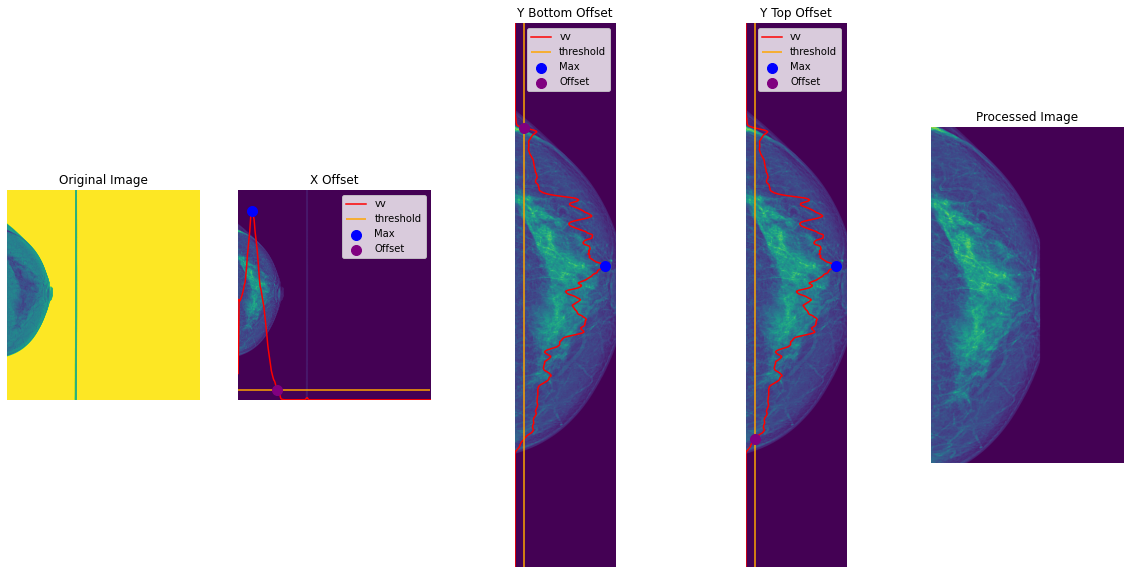

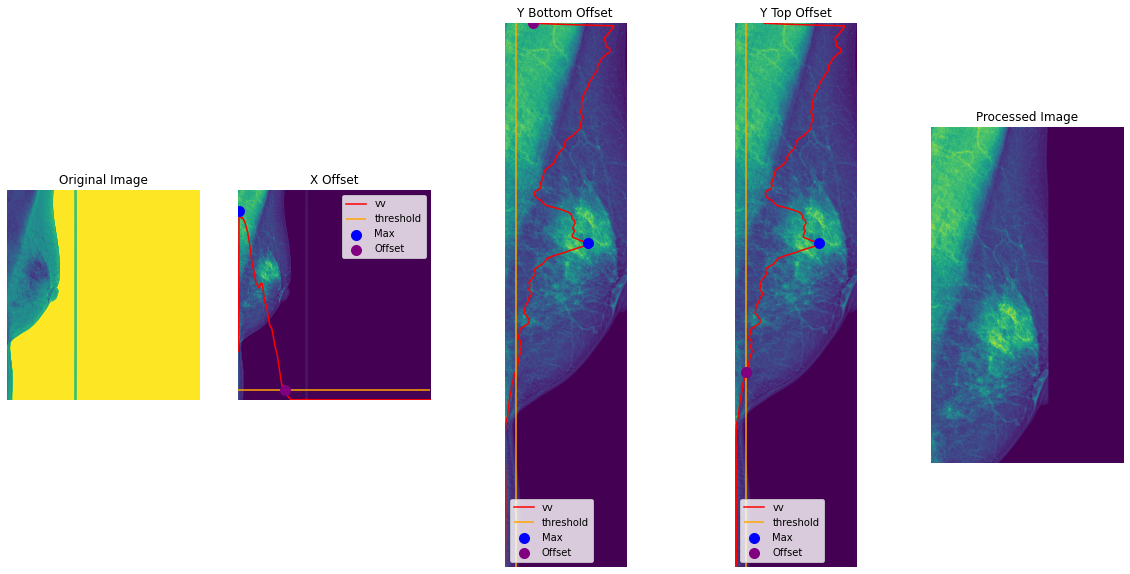

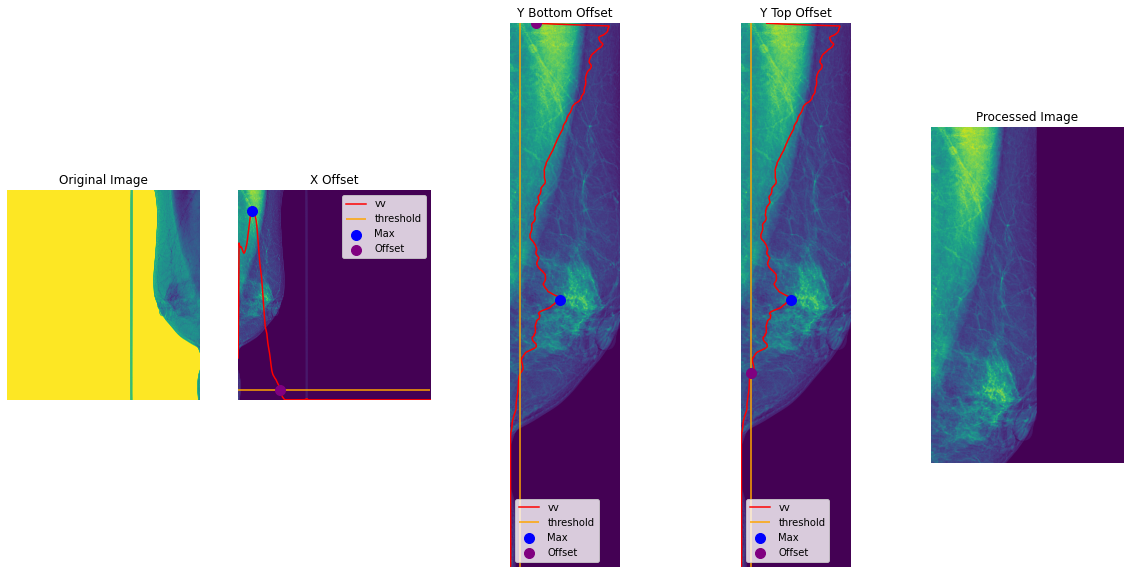

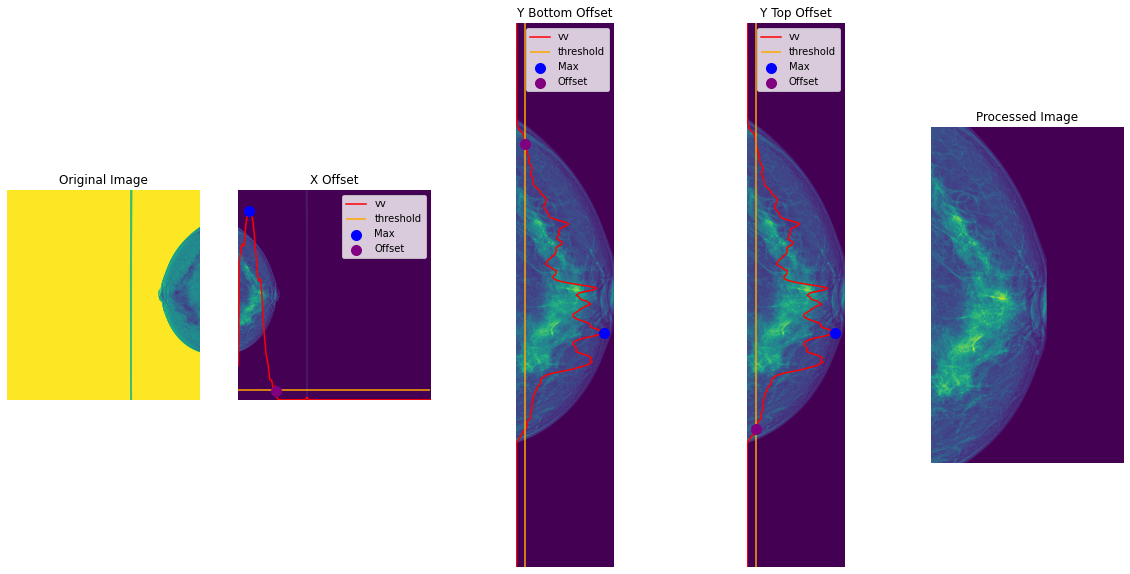

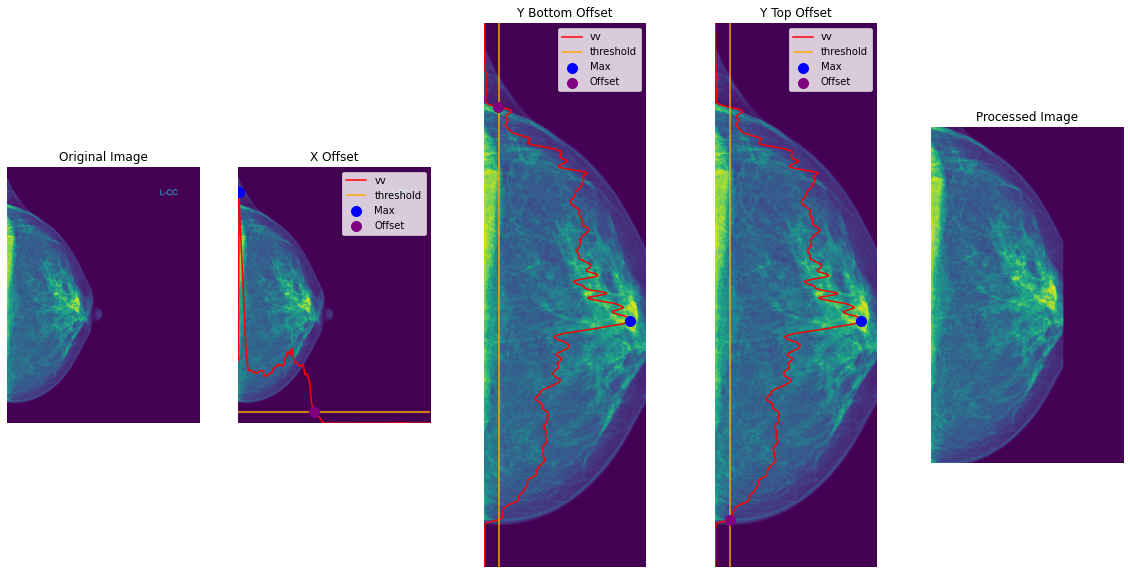

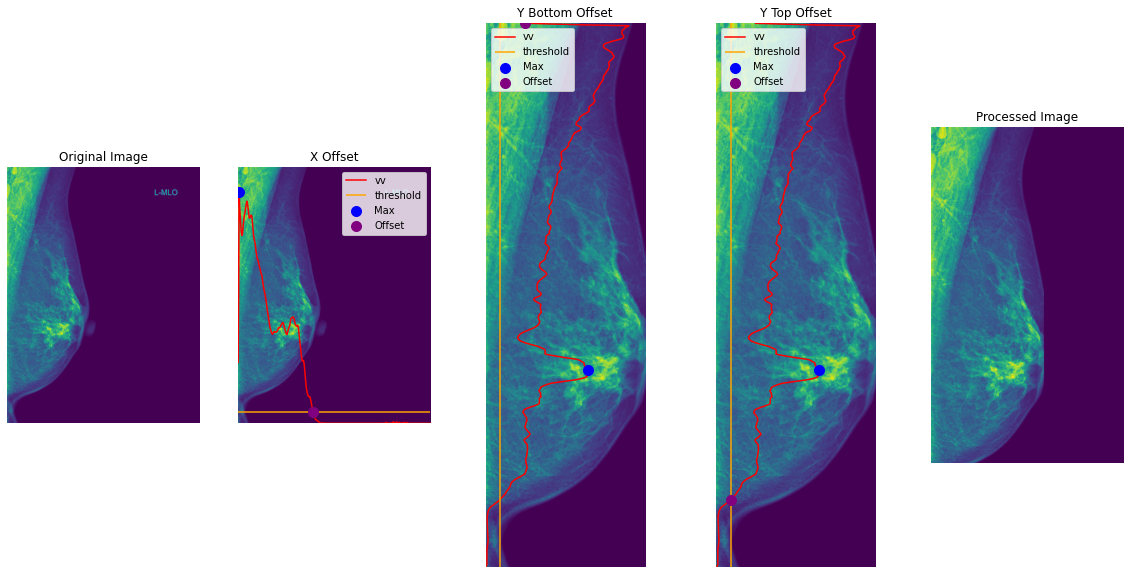

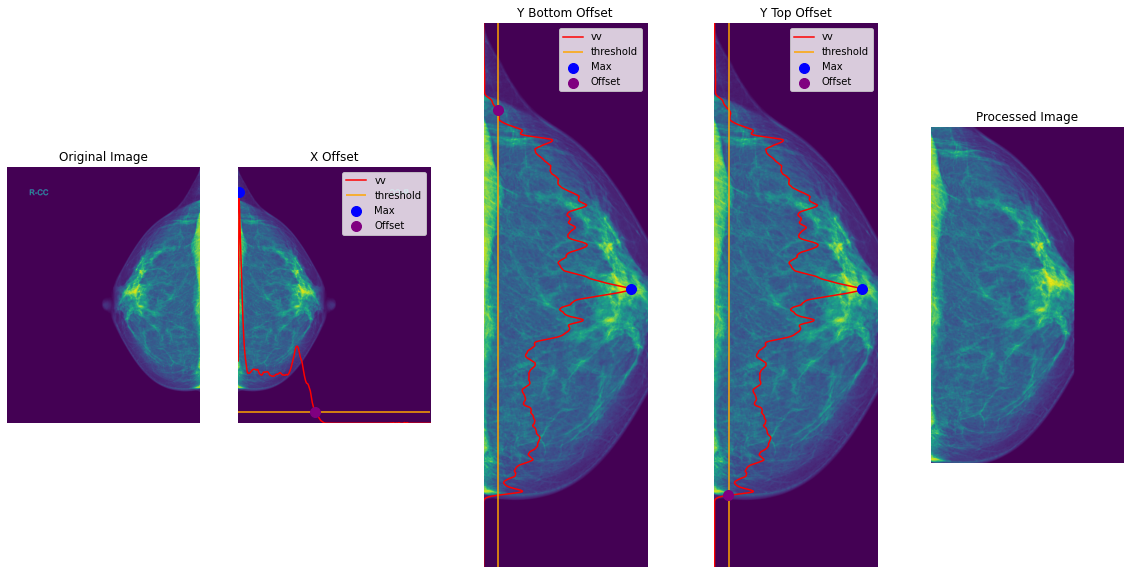

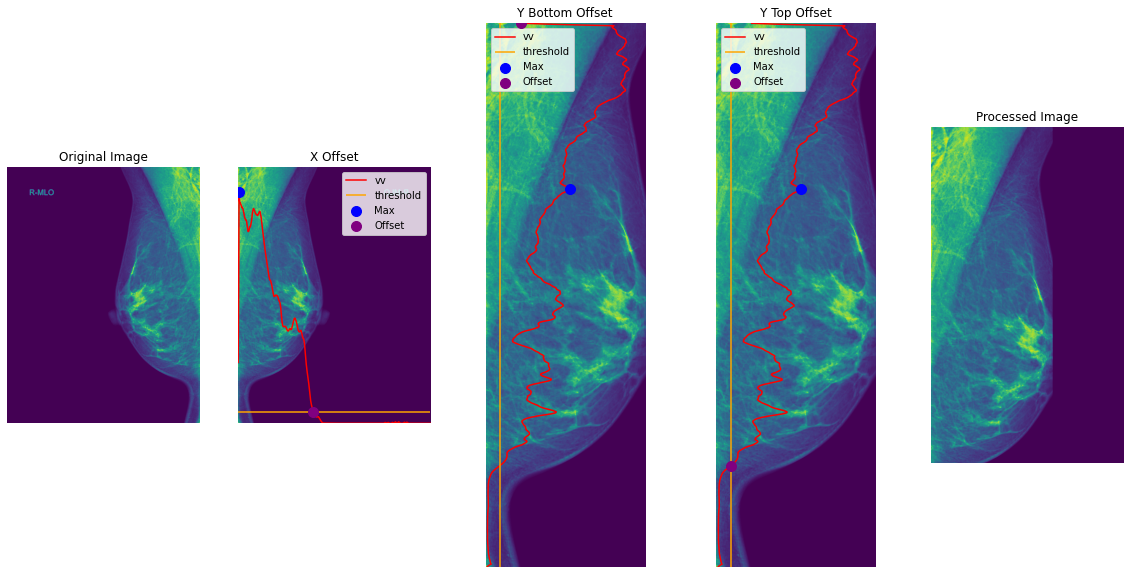

In [39]:

N = 8

for fp in tqdm(train['file_path'].head(N)):
    process(fp, crop_image=True, size=(TARGET_WIDTH, TARGET_HEIGHT), debug=True, save=False)

In [40]:
def normalize(image):
    image = tf.repeat(image, repeats=3, axis=3)
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.imagenet_utils.preprocess_input(image, mode='torch')

    return image


In [41]:
def get_model():
    image = tf.keras.layers.Input(INPUT_SHAPE, name='image', dtype=tf.uint8)
    image_norm = normalize(image)
    x = convnext.ConvNeXtV2Tiny(
        input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 3),
        pretrained=None,
        num_classes=0,
    )(image_norm)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.30)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=image, outputs=outputs)
    model.load_weights('/kaggle/input/rsna-efficientnetv2-training-tensorflow-tpu-ds/model.h5')
    model.trainable = False
    model.compile()

    return model

In [42]:
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True)
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 1344, 768, 1)]    0         
_________________________________________________________________
tf.repeat (TFOpLambda)       (None, 1344, 768, None)   0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 1344, 768, None)   0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 1344, 768, None)   0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 1344, 768, 3)      0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 1344, 768, 3)      0         
_________________________________________________________________
convnext_v2_tiny (Functional (None, 42, 24, 768)       278649

In [43]:
test = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')

def get_file_path(args):
    patient_id, image_id = args
    return f'/kaggle/input/rsna-breast-cancer-detection/test_images/{patient_id}/{image_id}.dcm'
    
test['file_path'] = test[['patient_id', 'image_id']].apply(get_file_path, axis=1)

display(test.info())
display(test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   site_id        4 non-null      int64 
 1   patient_id     4 non-null      int64 
 2   image_id       4 non-null      int64 
 3   laterality     4 non-null      object
 4   view           4 non-null      object
 5   age            4 non-null      int64 
 6   implant        4 non-null      int64 
 7   machine_id     4 non-null      int64 
 8   prediction_id  4 non-null      object
 9   file_path      4 non-null      object
dtypes: int64(6), object(4)
memory usage: 448.0+ bytes


None

site_id  patient_id    image_id laterality view  age  implant  machine_id  \
0        2       10008   736471439          L  MLO   81        0          21   
1        2       10008  1591370361          L   CC   81        0          21   
2        2       10008    68070693          R  MLO   81        0          21   
3        2       10008   361203119          R   CC   81        0          21   

  prediction_id                                          file_path  
0       10008_L  /kaggle/input/rsna-breast-cancer-detection/tes...  
1       10008_L  /kaggle/input/rsna-breast-cancer-detection/tes...  
2       10008_R  /kaggle/input/rsna-breast-cancer-detection/tes...  
3       10008_R  /kaggle/input/rsna-breast-cancer-detection/tes...

In [49]:
# Preprocess a single image and saves it
def preprocess_and_save_image(args):
    (patient_id, laterality), g = args
    cancer = 0.0
    for row_idx, row in g.iterrows():
        process(row['file_path'], size=(TARGET_WIDTH, TARGET_HEIGHT), crop_image=True, save=True)
    

In [50]:
# Preprocess all images in parallel using Joblib
jobs = [joblib.delayed(preprocess_and_save_image)(args) for args in test.groupby(['patient_id', 'laterality'])]
SUBMISSION_ROWS = joblib.Parallel(
    n_jobs=cpu_count(),
    verbose=1,
    backend='multiprocessing',
    prefer='threads',
)(jobs)

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.6s finished


In [52]:
sample_submission = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/sample_submission.csv')

display(sample_submission.info())
display(sample_submission.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   prediction_id  2 non-null      object 
 1   cancer         2 non-null      float64
dtypes: float64(1), object(1)
memory usage: 160.0+ bytes


None

prediction_id    cancer
0       10008_L  0.021168
1       10008_R  0.021168